# 2D to 3D Lifting Network

## Imports and Setup

In [1]:
import os
import src.bug_dataset
from src.lifting_network import LiftingNet
from src.train_network import TrainNetwork
import numpy as np
import pandas as pd
from skimage import io
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

In [22]:
# Plotting Code
%matplotlib widget
import matplotlib.pyplot as plt

def plot_stick_bug(ax, points, vis, prediction=False):
    limb_ranges=[[0,7],[8,14],[15,21],[22,28],[29,35],[36,42],[43,49],[53,56],[59,62]]
    if len(points) < 62:
        return
    elif len(points) == 62:
        points = np.array(points).T
        for num in range(len(limb_ranges)):
            visible_limb = []
            for x in range(limb_ranges[num][0],limb_ranges[num][1]):
                if vis[x]== 1:
                    visible_limb.append(x) 
            if prediction:
                line, = ax.plot(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb],'--', alpha=0.7, label='Prediction', color='red')
                ax.scatter(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], marker='X',s=10, color='red')
            else:
                line, = ax.plot(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], label='Actual', color='blue')
                ax.scatter(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], marker='o',s=4, color='blue')
        return ax, line

def set_axes_equal(ax):
    # workaround, as matplotlib's 3D plot has no option for equisised axes (10/2021)
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [3]:
target_dir = "../data/single_sungaya/"
out_df = pd.read_hdf(os.path.join(target_dir, "Data_3D_Pose.hdf5"))

In [4]:
sungaya_dataset = src.bug_dataset.BugDataset(df=out_df,
                             root_dir=target_dir,transform=transforms.Compose([
                                src.bug_dataset.ToTensor()
                                   ]))

In [5]:
train_split = 0.7
valid_split = 0.1
train_size = int(train_split * len(sungaya_dataset))
valid_size = int(valid_split * len(sungaya_dataset))
test_size = len(sungaya_dataset) - (train_size+valid_size)
train_dataset,valid_dataset ,test_dataset = torch.utils.data.random_split(sungaya_dataset, [train_size, valid_size, test_size], generator=torch.Generator().manual_seed(42))

In [6]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
reduceKeypoints = False
if reduceKeypoints:
    model = LiftingNet(2*29,1392,29)
else:
    model = LiftingNet(2*62,512,62)

accurate_dist = torch.from_numpy(np.nan_to_num(abs(([4,4,4]-sungaya_dataset.means_3d)/sungaya_dataset.std_3d)).T[2])
epochs = 5
learning_rate = 2.5e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
liftingtrainer = TrainNetwork(model,optimizer,accurate_dist,train_dataloader, valid_dataloader, reduceKeypoints)
trained_model = liftingtrainer.run(epochs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Using cuda device
Epoch 1
-------------------------------
loss: 0.412177  [    0/ 2286]
Validation Error: 
 Accuracy: 46.030675%, Avg loss: 0.276993 

Epoch 2
-------------------------------
loss: 0.264838  [    0/ 2286]
Validation Error: 
 Accuracy: 48.006135%, Avg loss: 0.235111 

Epoch 3
-------------------------------
loss: 0.224268  [    0/ 2286]
Validation Error: 
 Accuracy: 49.141104%, Avg loss: 0.213417 

Epoch 4
-------------------------------
loss: 0.202917  [    0/ 2286]
Validation Error: 
 Accuracy: 50.006135%, Avg loss: 0.198251 

Epoch 5
-------------------------------
loss: 0.187896  [    0/ 2286]
Validation Error: 
 Accuracy: 50.714724%, Avg loss: 0.186386 

Done!


In [8]:
trained_model.eval()
# Code get the first batch of results
with torch.no_grad():
    for data in test_dataloader:
        image = data['file_name']
        print(image)
        X = data['key_points_2D']
        y = data['key_points_3D']
        vis = data['visibility']
        # print(y)
        X, y = X.to(liftingtrainer.device, dtype=torch.float), y.to(liftingtrainer.device, dtype=torch.float)
        pred = trained_model(X)
        break


['7744_Img_synth.png', '6328_Img_synth.png', '8205_Img_synth.png', '3300_Img_synth.png', '8804_Img_synth.png', '7738_Img_synth.png', '5504_Img_synth.png', '30_Img_synth.png', '6788_Img_synth.png', '4050_Img_synth.png', '9484_Img_synth.png', '6573_Img_synth.png', '4319_Img_synth.png', '5333_Img_synth.png', '9066_Img_synth.png', '2903_Img_synth.png', '8488_Img_synth.png', '8473_Img_synth.png', '1305_Img_synth.png', '422_Img_synth.png', '7953_Img_synth.png', '1735_Img_synth.png', '2540_Img_synth.png', '2073_Img_synth.png', '9808_Img_synth.png', '6223_Img_synth.png', '5020_Img_synth.png', '8117_Img_synth.png', '980_Img_synth.png', '9378_Img_synth.png', '3251_Img_synth.png', '4909_Img_synth.png', '6471_Img_synth.png', '244_Img_synth.png', '5294_Img_synth.png', '7880_Img_synth.png', '6589_Img_synth.png', '255_Img_synth.png', '5435_Img_synth.png', '5592_Img_synth.png', '9725_Img_synth.png', '8176_Img_synth.png', '8758_Img_synth.png', '8028_Img_synth.png', '4407_Img_synth.png', '9127_Img_synth

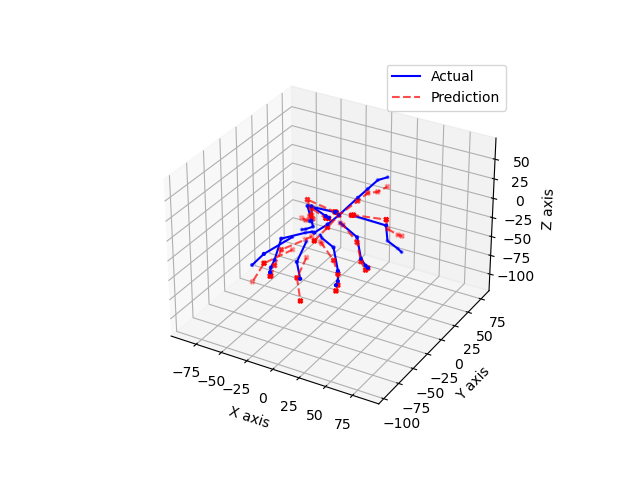

In [23]:
sample = 1
# print(image[sample])
prediction = (pred[sample].cpu()).numpy()
actual = (y[sample].cpu()).numpy()

visibility_mask = vis[sample]
mean = sungaya_dataset.means_3d[:,2]
std = sungaya_dataset.std_3d[:,2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

unnormalised_acc = (actual*sungaya_dataset.std_3d)+sungaya_dataset.means_3d
ax, line1 = plot_stick_bug(ax, unnormalised_acc, visibility_mask)


unnormalised_est = unnormalised_acc
unnormalised_est[:,2] = (prediction*std)+mean
ax, line2 = plot_stick_bug(ax, unnormalised_acc, visibility_mask, True)

plt.legend(handles=[line1,line2], loc='upper right')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# use custom function to ensure equal axis proportions
set_axes_equal(ax)
# opens external plot
plt.show()